In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math

from sklearn import svm, neighbors, tree, ensemble, model_selection, metrics

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss, RandomUnderSampler
from imblearn import ensemble as imb_ensemble

from joblib import Parallel, delayed

sns.set_theme()
sns.axes_style("whitegrid")
sns.set_context("paper")

## TODO
- Create functions for different 'types' of datasets
- Explain the different cells using markdown
- Turn into presentation?

### Feedback to be integrated
- Noise not uniform, but binomially distributed

In [60]:
data_folder = "data/traces/"

def read_date(date: str):
    """Aggregate data of a single from parts"""
    data = pd.DataFrame()

    for i in range(50):
        try:
            frame = pd.read_csv(data_folder + date + "-{}.csv".format(i))
            data = pd.concat([data, frame], axis=0)
        except OSError:
            pass

    return data


def read_date_part(date_part: str):
    """Read data of a part of a capture date"""
    data = pd.DataFrame()

    try:
        frame = pd.read_csv(data_folder + date_part + ".csv")
        data = pd.concat([data, frame], axis=0)
    except OSError:
        pass

    return data

def read_all_data():
    dates = ["16-09", "16-10", "16-11"]
    data = pd.DataFrame()

    for date in dates:
        try:
            data = pd.concat([data, read_date(date)])
        except OSError:
            pass

    return data

# data = read_all_data()
data = read_date_part("16-09-24")

data.columns = ["packet_id","timestamp","packet_size", "eth_src", "device_name" ,"protocol", "iot"]
data.set_index("timestamp")

display(data)

ValueError: Length mismatch: Expected axis has 0 elements, new values have 7 elements

In [10]:
def filter_icmp(df: pd.DataFrame):
    return df.loc[(df['protocol'] != "ICMP") | (df['protocol'] != "ICMPv6")]

data_no_icmp = filter_icmp(data)
display(data_no_icmp)

,packet_id,timestamp,packet_size,eth_src,protocol
0,1,1474552802257569000,70,18:b7:9e:02:20:44,TCP
1,2,1474552802257692000,66,18:b7:9e:02:20:44,TCP
2,3,1474552802323085000,66,14:cc:20:51:33:ea,TCP
3,4,1474552802383174000,60,d0:52:a8:00:67:5e,TCP
4,5,1474552802396326000,98,14:cc:20:51:33:ea,ICMP
...,...,...,...,...,...
947067,947068,1474639199059331000,54,14:cc:20:51:33:ea,TCP
947068,947069,1474639199620186000,60,00:24:e4:11:18:a8,ARP
947069,947070,1474639199620225000,42,14:cc:20:51:33:ea,ARP
947070,947071,1474639199771064000,156,30:8c:fb:2f:e4:b2,TLSv1


In [11]:
def attach_window_id(timestamped_frame: pd.DataFrame) -> list[pd.DataFrame]:
    """Slice the dataframe into 1-second intervals"""
    first_packet_time = timestamped_frame.iloc[0]['timestamp']
    last_packet_time = timestamped_frame.iloc[-1]['timestamp']
    windowed_frame = timestamped_frame.set_index('timestamp', drop=False) 

    ns_in_sec = int(1e9)
    number_of_windows = int((last_packet_time - first_packet_time) / ns_in_sec) + 1

    try:
        windowed_frame.insert(0, value=0, column="window_id")
    except Exception as e:
        print("It seems like the column 'window_id' already exists. Just updating values...")
        print(e)
    finally:
        windowed_frame.window_id.astype(np.int64)

    for window_id in range(0, number_of_windows):
        from_time = first_packet_time + window_id * ns_in_sec
        to_time = first_packet_time + (window_id  + 1) * ns_in_sec
        windowed_frame.loc[from_time:to_time, 'window_id'] = window_id
    
    windowed_frame.set_index('window_id', inplace=True)
    return windowed_frame


def attach_window_id_fast(timestamped_frame: pd.DataFrame) -> pd.DataFrame:
    first_packet_time = timestamped_frame.iloc[0]['timestamp']
    last_packet_time = timestamped_frame.iloc[-1]['timestamp']

    ns_in_sec = int(1e9)
    windows = range(first_packet_time - 1, last_packet_time + ns_in_sec, ns_in_sec)

    windowed_frame = pd.cut(timestamped_frame['timestamp'], windows, labels=range(len(windows) - 1)).to_frame()
    windowed_frame.columns = ["window_id"]
    return pd.concat([timestamped_frame, windowed_frame], axis=1).set_index('window_id')
    

devices = pd.read_csv("data/list_of_devices.csv")
windowed_frame = attach_window_id_fast(data)

display(windowed_frame)

,packet_id,timestamp,packet_size,eth_src,protocol
window_id,,,,,
0,1,1474552802257569000,70,18:b7:9e:02:20:44,TCP
0,2,1474552802257692000,66,18:b7:9e:02:20:44,TCP
0,3,1474552802323085000,66,14:cc:20:51:33:ea,TCP
0,4,1474552802383174000,60,d0:52:a8:00:67:5e,TCP
0,5,1474552802396326000,98,14:cc:20:51:33:ea,ICMP
...,...,...,...,...,...
86396,947068,1474639199059331000,54,14:cc:20:51:33:ea,TCP
86397,947069,1474639199620186000,60,00:24:e4:11:18:a8,ARP
86397,947070,1474639199620225000,42,14:cc:20:51:33:ea,ARP


In [12]:
def generate_features_labeled(windowed_frame: pd.DataFrame, device_frame: pd.DataFrame, padded=False, exclude_devices=[]):
    """Calculate the mode, mean, and median of a window"""
    if padded:
        windowed_frame = pad_data(windowed_frame) 

    features = pd.DataFrame()

    for device_index in device_frame.index:
        device = device_frame.iloc[device_index]
        device_name = device['device_name']

        if device_name in exclude_devices:
            print("Excluding {}...".format(device_name))
            continue

        device_packets = windowed_frame.loc[windowed_frame['eth_src'] == device['eth_src']]
        device_features = generate_features(device_packets)

        device_features.insert(len(device_features.columns), "device_name", device_name)
        device_features.insert(len(device_features.columns), "iot", device['iot'])

        features = pd.concat([features, device_features])

    features.columns = ["mean", "std", "n_bytes", "device_name", "iot"]
    return features

def generate_features(windowed_frame: pd.DataFrame):
    window_groups = windowed_frame.groupby("window_id", observed=True)

    mean = window_groups['packet_size'].mean()
    std = window_groups['packet_size'].std()
    n_bytes = window_groups['packet_size'].sum()

    # TODO Not sure if fillna is a good idea
    return pd.concat([mean, std, n_bytes], axis=1).fillna(0)

def _round_to(value, rounding=100.0):
    return int(np.ceil(value / rounding)) * rounding

def pad_data(windowed_frame, rounding=100.0):
    padded = windowed_frame.copy()
    padded['packet_size'] = padded['packet_size'].apply(lambda x: _round_to(x, rounding=rounding))
    return padded

def get_devices_in_window(windowed_frame: pd.DataFrame):
    devices_in_window = pd.DataFrame()
    
    for window_id in windowed_frame.index.unique():
        devices = windowed_frame.loc[window_id]['device_name']
        # iot = windowed_frame.loc[window_id]['iot']

        if not isinstance(devices, str):
            devices = devices.unique() 
            
        devices_in_window = pd.concat([devices_in_window, pd.DataFrame({"window_id": window_id, "devices": devices})])

    return devices_in_window

labeled_features = generate_features_labeled(windowed_frame, devices)
labeled_features_padded = generate_features_labeled(windowed_frame, devices, padded=True)
labeled_features_no_cam = generate_features_labeled(windowed_frame, devices, 
                                                    exclude_devices=["Samsung SmartCam", "Dropcam", "Insteon Camera", "Nest Dropcam", "Withings Smart Baby Monitor", "TP-Link Day Night Cloud camera", "Netatmo Welcome"])

display(devices)
display(labeled_features)
display(labeled_features_padded)
display(labeled_features_no_cam)

Excluding Netatmo Welcome...
Excluding TP-Link Day Night Cloud camera...
Excluding Samsung SmartCam...
Excluding Dropcam...
Excluding Insteon Camera...
Excluding Withings Smart Baby Monitor...
Excluding Nest Dropcam...


,device_name,eth_src,connection_type,iot
0,Smart Things,d0:52:a8:00:67:5e,Wired,True
1,Amazon Echo,44:65:0d:56:cc:d3,Wireless,True
2,Netatmo Welcome,70:ee:50:18:34:43,Wireless,True
3,TP-Link Day Night Cloud camera,f4:f2:6d:93:51:f1,Wireless,True
4,Samsung SmartCam,00:16:6c:ab:6b:88,Wireless,True
5,Dropcam,30:8c:fb:2f:e4:b2,Wireless,True
6,Insteon Camera,00:62:6e:51:27:2e,Wired,True
7,Unknown,e8:ab:fa:19:de:4f,Wireless,False
8,Withings Smart Baby Monitor,00:24:e4:11:18:a8,Wired,True
9,Belkin Wemo switch,ec:1a:59:79:f4:89,Wireless,True


,mean,std,n_bytes,device_name,iot
window_id,,,,,
0,60.000000,0.000000,60,Smart Things,True
1,99.500000,55.861436,199,Smart Things,True
11,60.000000,0.000000,60,Smart Things,True
16,60.000000,0.000000,60,Smart Things,True
21,60.000000,0.000000,60,Smart Things,True
...,...,...,...,...,...
86393,82.666667,51.081634,248,TPLink Router Bridge LAN (Gateway),False
86394,66.000000,0.000000,132,TPLink Router Bridge LAN (Gateway),False
86395,42.000000,0.000000,42,TPLink Router Bridge LAN (Gateway),False


,mean,std,n_bytes,device_name,iot
window_id,,,,,
0,100.000000,0.000000,100.0,Smart Things,True
1,150.000000,70.710678,300.0,Smart Things,True
11,100.000000,0.000000,100.0,Smart Things,True
16,100.000000,0.000000,100.0,Smart Things,True
21,100.000000,0.000000,100.0,Smart Things,True
...,...,...,...,...,...
86393,133.333333,57.735027,400.0,TPLink Router Bridge LAN (Gateway),False
86394,100.000000,0.000000,200.0,TPLink Router Bridge LAN (Gateway),False
86395,100.000000,0.000000,100.0,TPLink Router Bridge LAN (Gateway),False


,mean,std,n_bytes,device_name,iot
window_id,,,,,
0,60.000000,0.000000,60,Smart Things,True
1,99.500000,55.861436,199,Smart Things,True
11,60.000000,0.000000,60,Smart Things,True
16,60.000000,0.000000,60,Smart Things,True
21,60.000000,0.000000,60,Smart Things,True
...,...,...,...,...,...
86393,82.666667,51.081634,248,TPLink Router Bridge LAN (Gateway),False
86394,66.000000,0.000000,132,TPLink Router Bridge LAN (Gateway),False
86395,42.000000,0.000000,42,TPLink Router Bridge LAN (Gateway),False


In [53]:
from enum import StrEnum

class Balancing(StrEnum):
    NONE = "none"
    STRATIFIED = "stratified"
    OVER_UNDER = "over_under"
    OVER_UNDER_RUS = "over_under_rus"
    OVER = "over"
    UNDER = "under"
    UNDER_RUS = "under_rus"

def _balance_over_under(X, y, rus=False, random_state: int | None = None, undersample=True, oversample=True):
    oversampling = SMOTE(random_state=random_state)

    # Resource [32] is actually really old (2009), NearMiss is a better alternative than RUS
    # but I left it as an option
    if rus:
        undersampling = RandomUnderSampler(random_state=random_state)
    else:
        undersampling = NearMiss()

    if oversample:
        X, y = oversampling.fit_resample(X, y)
    if undersample:
        X, y = undersampling.fit_resample(X, y)

    return X, y

def _get_models():
    models = {
        "k-NN" : neighbors.KNeighborsClassifier(n_neighbors=5, weights="distance"),
        "DT"  : tree.DecisionTreeClassifier(),
        "RF"  : ensemble.RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0),
        # "SVM" : svm.SVC(),
    }
    params = {
        "k-NN" : 
            {'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 20, 40], 'weights' : ["distance", "uniform"]},
        "DT" : {'max_depth' : [None, 5, 8, 10] ,'min_samples_split' : [2, 3, 4, 5]},
        "RF" : { 'n_estimators' : [1, 2, 3, 4, 5, 7, 10], 'max_depth' : [None, 5, 8, 10] ,'min_samples_split' : [2, 3, 4, 5] },
        # "SVM" : {},
    }
    # I don't really see the advantage of using an ensemble balancing method in conjuction with the
    # under- and oversample techniques. I can't find any indication in the paper the referenced [32]
    # that it actually works. So, I'm just keeping this here.
    models["Majority Voting"] = ensemble.VotingClassifier(list(models.items()))
    params["Majority Voting"] = {'voting' : ['hard', 'soft']}

    return models, params

def _using_kfold(n_splits):
    return n_splits > 1

def _trained_model_name(scores):
    return "{}_{}_{}".format(scores["model"][-1], scores["label"][-1], scores["balancing"][-1])

def _evaluate(model_name: str, measurement: str, value: float, target_label: str, balancing: Balancing, scores={}):
    if len(scores.keys()) == 0:
        scores = {"model" : [], "measurement" : [], "value" : [], "label" : [], "balancing" : []}

    scores["model"].append(model_name)
    scores["measurement"].append(measurement)
    scores["value"].append(value)
    scores["label"].append(target_label)
    scores["balancing"].append(balancing)

    return scores

def _specificity(y_true, y_pred):
    cm = metrics.confusion_matrix(y_true, y_pred)

    num_classes = cm.shape[0]
    specificity = []

    for i in range(num_classes):
        tn = np.sum(np.delete(np.delete(cm, i, axis=0), i, axis=1))
        fp = np.sum(np.delete(cm, i, axis=0)[:, i])

        if tn + fp == 0.0:
            specificity.append(0.0)
        else:
            specificity.append(tn / (tn + fp))
    
    return sum(specificity) / len(specificity)

def _geometric_mean(*scores):
    return np.prod(scores) ** (1.0/len(scores))

def _evaluate_model(model, X_test, y_test, model_name, target_label: str, balancing: Balancing, scores={}):
    predictions = model.predict(X_test)
    accuracy = metrics.accuracy_score(y_test, predictions)
    specificity = _specificity(y_test, predictions)

    # As we have quite a number of devices, there is chance that some class in y_test is not in the predictions.
    # In this case, the precision and recall cannot be calculated as there are no positives (either true, or false)
    # which results in a zero dvisions error. In our case, this means that the classifier has misclassified something,
    # and we 'punish' it by returning zero. This should occur less as the test size increases
    precision, recall, fscore, _ = metrics.precision_recall_fscore_support(y_test, predictions, average='macro', zero_division=0.0)
    geo_mean = _geometric_mean(accuracy, precision, recall, fscore, specificity)

    scores = _evaluate(model_name, "accuracy", accuracy, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "recall", recall, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "fscore", fscore, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "precision", precision, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "specificity", specificity, target_label, balancing, scores=scores)
    scores = _evaluate(model_name, "geo_mean", geo_mean, target_label, balancing, scores=scores)

    return scores

def _custom_tuner(X_train, y_train, models_and_params=None, balancing=Balancing.NONE, target_label=None, n_splits=10, n_jobs=-1):
    if n_splits < 2:
        print("Cannot use hyper parameter tuning with less than 2 splits. Defaulting to 10.")
        n_splits = 10
    if balancing == Balancing.STRATIFIED:
        print("Warning: Stratified balancing with hyper parameter tuning is effectively Balancing.NONE")
    
    models, params = _get_models() if models_and_params is None else models_and_params
    scores = {}
    trained = {}

    for (name, model) in models.items():
        # hardcoded, but I can't think of a 'nicer' solution atm
        if name == "Majority Voting":
            model = ensemble.VotingClassifier(list(trained.items())) 

        tuning = model_selection.GridSearchCV(
                model, 
                params[name], 
                scoring = ["f1_macro"], 
                refit="f1_macro",
                cv=n_splits,
                n_jobs=n_jobs
            )
        tuning.fit(X_train, y_train)

        scores = _evaluate(name, "fscore", tuning.best_score_, target_label=target_label, balancing=balancing, scores=scores)
        trained[name] = tuning.best_estimator_

    return trained, pd.DataFrame(scores)

def _train_model(model, X_train, X_test, y_train, y_test, target_label, balancing):
    trained_model = model[1].fit(X_train, y_train)
    scores = _evaluate_model(trained_model, X_test, y_test, model_name=model[0], target_label=target_label, balancing=balancing)

    return (model[0], trained_model), scores


def _custom_kfold(X_train, y_train, models_and_params=None, target_label=None, balancing=Balancing.NONE, kf=None, parallelize=False):
    models, _ = _get_models() if models_and_params is None else models_and_params
    scores = None
    trained = {}

    if kf is not None:
        folds = [ (X_train.iloc[train], X_train.iloc[test], y_train.iloc[train], y_train.iloc[test]) for (train, test) in kf.split(X_train, y_train) ]
    else:
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X_train, y_train, test_size=.25)
        folds = [ (X_train, X_test, y_train, y_test) ]
    
    out = []

    if parallelize:
        out = Parallel(n_jobs=len(models.keys()), verbose=0, pre_dispatch='1.5*n_jobs')(
            delayed(_train_model)(model, X_train, X_test, y_train, y_test, target_label, balancing) 
            for model in models.items() 
            for (X_train, X_test, y_train, y_test) in folds
        )
    else: 
        for model in models.items():
            for (X_train, X_test, y_train, y_test) in folds:
                out.append(_train_model(model, X_train, X_test, y_train, y_test, target_label, balancing))

    for (model_name, trained_model), score in out:
        trained[model_name] = trained_model

        if scores is None:
            scores = score
        else:
            for (key, values) in score.items():
                scores[key] += values

    return trained, pd.DataFrame(scores)


def train_and_test_classifiers(labeled_features, target_label, balancing=Balancing.NONE, n_splits=10, shuffle=False, random_state=None, tuned=False):
    """
    Trains and tests a series of models on the given, labeled data
    (Knn, RF, DT, SVM, Majority Voting)

    When n_splits < 2, KFold is not used and the test set has a size of 25% of the whole dataset
    """
    assert not (balancing == Balancing.STRATIFIED and not _using_kfold(n_splits)) # KFold cannot be disabled if using the stratified balancing strategy
    
    # If there is no balancing, we condsider the original dataset to be balanced
    # thus, it is balanced by default
    X_bal = labeled_features.iloc[:, 1:3]
    y_bal = labeled_features.iloc[:][target_label]
    X_ubal = None
    y_ubal = None

    kf = model_selection.KFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state) if _using_kfold(n_splits) else None

    # If we're balancing the data itself, we should keep an unbalanced set (ubal) as testing set
    if balancing != Balancing.NONE:
        X_bal, X_ubal, y_bal, y_ubal = model_selection.train_test_split(X_bal, y_bal, test_size=.1)

    if balancing == Balancing.OVER_UNDER:
        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=random_state)
    if balancing == Balancing.OVER_UNDER_RUS:
        X_bal, y_bal = _balance_over_under(X_bal, y_bal, rus=True, random_state=random_state)
    if balancing == Balancing.STRATIFIED:
        kf = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    print("Training {} classifier with balancing: '{}' and {} folds".format(target_label, balancing, n_splits if n_splits > 1 else "without"))

    if tuned:
        trained, scores_bal = _custom_tuner(X_bal, y_bal, n_splits=n_splits, balancing=balancing, target_label=target_label)
    else:
        trained, scores_bal = _custom_kfold(X_bal, y_bal, kf=kf, balancing=balancing, target_label=target_label) 

    # If we haven't done balancing, the scores are good as they are
    if balancing == Balancing.NONE:
        return trained, scores_bal

    # Otherwise, we should test on the unbalanced datasets
    scores_ubal = {}
    for (name, model) in trained.items():
        simple_name = name.split("_")[0]
        scores_ubal = _evaluate_model(model, X_ubal, y_ubal, 
                                      simple_name, target_label=target_label, 
                                      balancing=balancing, scores=scores_ubal)

    return trained, pd.DataFrame(scores_ubal)

In [ ]:
class Trainer():
    def __init__(self, labeled_features, target_label, balancing=Balancing.NONE, 
                 random_state=42, n_splits=10, shuffle=False, test_size=.1, 
                 eval_size=.25, with_tuning=False) -> None:
        self.balancing = balancing 
        self.target_label = target_label
        self.with_tuning = with_tuning

        self.models, self._hyper_params = _get_models()
        self._params = None
        self.trained_models = None

        self._random_state = random_state
        self._shuffle = shuffle
        self._n_splits = n_splits

        self._init_kf()
        self._init_data(labeled_features)

        print("Initialized {} trainer on {} datapoints with {} features and {} labels".format(target_label, len(labeled_features[target_label]), len(self.unbalanced[0].columns), len(labeled_features[target_label].unique())))

    def _init_data(self, labeled_features):
        X_bal = labeled_features.iloc[:, 0:3]
        y_bal = labeled_features.iloc[:][self.target_label]

        self.unbalanced = (X_bal, None, y_bal, None)

        X_bal, X_ubal, y_bal, y_ubal = model_selection.train_test_split(X_bal, y_bal, test_size=.1)
        self.balanced =  (X_bal, X_ubal, y_bal, y_ubal)

        
        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=self._random_state, oversample=True, undersample=False)
        self.over = (X_bal, X_ubal, y_bal, y_ubal)
        
        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=self._random_state, oversample=False, undersample=True)
        self.under = (X_bal, X_ubal, y_bal, y_ubal)

        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=self._random_state, oversample=False, undersample=True, rus=True)
        self.under_rus = (X_bal, X_ubal, y_bal, y_ubal)

        X_bal, y_bal = _balance_over_under(X_bal, y_bal, random_state=self._random_state)
        self.over_under = (X_bal, X_ubal, y_bal, y_ubal)

        X_bal, y_bal = _balance_over_under(X_bal, y_bal, rus=True, random_state=self._random_state)
        self.over_under_rus = (X_bal, X_ubal, y_bal, y_ubal)

    def _init_kf(self):
        random_state = self._random_state if self.shuffle else None

        self.kf_strat = model_selection.StratifiedKFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=random_state) if self.using_kfold else None
        self.kf = model_selection.KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=random_state) if self.using_kfold else None
        
    @property
    def params(self):
        return self._params

    @params.setter
    def params(self, params):
        self._params = params
        
        for (name, model) in self.models.items():
            model.set_params(**self._params[name])
    
    @property
    def n_splits(self):
        return self._n_splits
    
    @n_splits.setter
    def n_splits(self, n_splits):
        self._n_splits = n_splits
        self._init_kf()
        return self

    @property
    def shuffle(self):
        return self._shuffle

    @shuffle.setter
    def shuffle(self, shuffle):
        self._shuffle = shuffle
        self._init_kf()
        return self

    @property
    def using_kfold(self):
        return self.n_splits > 1
   
    def train_models(self, balancing=None, with_tuning=None, parallelize=True):
        if balancing is None:
            balancing = self.balancing
        if with_tuning is None:
            with_tuning = self.with_tuning

        assert not (balancing == Balancing.STRATIFIED and not self.using_kfold)

        data = self._data(balancing)
        kf = self.kf

        if balancing == Balancing.STRATIFIED:
            data = self.balanced
            kf = self.kf_strat

        X_train, X_test, y_train, y_test = data
        print("Training {} classifier with balancing: '{}' and {} folds".format(
            self.target_label, balancing, 
            self.n_splits if self.using_kfold else "without", 
            "(parallelized)" if parallelize else ""))

        if with_tuning and self.params is None:
            self.tune() 

        trained, scores_bal = _custom_kfold(X_train, y_train, models_and_params=(self.models, self.params), 
                                            kf=kf, balancing=balancing, target_label=self.target_label, 
                                            parallelize=parallelize) 

        # If we haven't done balancing, the scores are good as they are
        if balancing == Balancing.NONE:
            return trained, scores_bal

        # Otherwise, we should test on the unbalanced datasets
        self.trained_models = trained
        scores_ubal = self.test(X_test, y_test, balancing=balancing)

        return trained, scores_ubal

    def test(self, X_test, y_test, trained=None, balancing=None):
        if balancing is None:
            balancing = self.balancing
        if trained is None:
            trained = self.trained_models

        scores = {}
        for (name, model) in trained.items():
            scores = _evaluate_model(model, X_test, y_test, 
                                        name, target_label=self.target_label, 
                                        balancing=balancing, scores=scores)

        return pd.DataFrame(scores)


    def tune(self):
        data = self._data()

        X_train, _, y_train, _ = data
        print("Optimizing {} trainer with balancing: '{}' and {} folds {}".format(
            self.target_label, self.balancing, self.n_splits if self.using_kfold else "10 (default)"))

        trained, scores = _custom_tuner(X_train, y_train, models_and_params=(self.models, self._hyper_params), 
                                            n_splits=self.n_splits, balancing=self.balancing, target_label=self.target_label)
        params = {}

        for (name, model) in trained.items():
            params[name] = model.get_params()

        self.params = params
        return params, scores

        
    def _data(self, balancing):
        data = self.unbalanced
        
        if balancing == Balancing.OVER:
            data = self.over
        if balancing == Balancing.UNDER:
            data = self.under
        if balancing == Balancing.UNDER_RUS:
            data = self.under_rus
        if balancing == Balancing.OVER_UNDER:
            data = self.over_under
        if balancing == Balancing.OVER_UNDER_RUS:
            data = self.over_under_rus

        return data

class IotTrainer(Trainer):
    def __init__(self, labeled_features) -> None:
        super().__init__(labeled_features, target_label='iot', n_splits=1, balancing=Balancing.OVER_UNDER_RUS)

class DeviceTrainer(Trainer):
    def __init__(self, iot_features) -> None:
        super().__init__(iot_features, target_label='device_name', n_splits=10, balancing=Balancing.STRATIFIED) 

In [41]:
iot_trainer = IotTrainer(labeled_features)
device_trainer = DeviceTrainer(labeled_features.loc[labeled_features['iot'] == True])

Initialized iot trainer on 285509 datapoints with 3 features and 2 labels
Initialized device_name trainer on 180923 datapoints with 3 features and 16 labels


In [42]:
# Turned off because this only has to be ran once, and takes a long time.
import warnings

tuning = False

if tuning:
    iot_best_params, iot_scores = iot_trainer.tune()
    device_best_params, device_scores = device_trainer.tune()
else:
    try: 
        iot_trainer.params = iot_best_params
        device_trainer.params = device_best_params
        warnings.warn("Tuning is currently turned off. Using preexisting tuned parameters.")
    except NameError:
        warnings.warn("Tuning is currently turned off and no preexisting tuned parameters could be found. Using default model values.")

/tmp/ipykernel_442/3804555367.py:15: UserWarning: Tuning is currently turned off and no preexisting tuned parameters could be found. Using default model values.
  warnings.warn("Tuning is currently turned off and no preexisting tuned parameters could be found. Using default model values.")


In [43]:
def _parse_experiments(experiments):
    trained_classifiers = [ experiment[0] for experiment in experiments ]
    all_scores = pd.concat([ experiment[1] for experiment in experiments ])

    return trained_classifiers, all_scores

def run_iot_experiments(trainer: Trainer| None = None, labeled_features: pd.DataFrame | None = None):
    if trainer is None:
        assert labeled_features is not None
        trainer = IotTrainer(labeled_features)

    experiments = [
        trainer.train_models(balancing=Balancing.OVER), 
        trainer.train_models(balancing=Balancing.UNDER_RUS),
    ]

    return _parse_experiments(experiments)

def run_device_experiments(trainer: Trainer| None = None, labeled_features: pd.DataFrame | None = None):
    if trainer is None:
        assert labeled_features is not None

        device_features = labeled_features.loc[labeled_features['iot'] == True]
        trainer = DeviceTrainer(device_features)

    experiments = [
        trainer.train_models(balancing=Balancing.STRATIFIED),
    ]

    return _parse_experiments(experiments)

def run_all_experiments(iot_trainer=None, device_trainer=None, labeled_features=None):
    iot_models, iot_scores = run_iot_experiments(trainer=iot_trainer, labeled_features=labeled_features)
    device_models, device_scores = run_device_experiments(trainer=device_trainer, labeled_features=labeled_features)

    return iot_models + device_models, pd.concat([iot_scores, device_scores])

## Experiment Results

### Experiment 1: Reproducing

In [44]:
all_trained_clfs, all_scores = run_all_experiments(iot_trainer=iot_trainer, device_trainer=device_trainer)

display(all_scores)
all_scores.groupby(['label', 'balancing', 'measurement', 'model']).mean()

Training iot classifier with balancing: 'over' and without folds
Training iot classifier with balancing: 'under_rus' and without folds
Training device_name classifier with balancing: 'stratified' and 10 folds


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


,model,measurement,value,label,balancing
0,k-NN,accuracy,0.875731,iot,over
1,k-NN,recall,0.883733,iot,over
2,k-NN,fscore,0.870724,iot,over
3,k-NN,precision,0.864956,iot,over
4,k-NN,specificity,0.883733,iot,over
...,...,...,...,...,...
19,Majority Voting,recall,0.632596,device_name,stratified
20,Majority Voting,fscore,0.649244,device_name,stratified
21,Majority Voting,precision,0.766964,device_name,stratified
22,Majority Voting,specificity,0.988275,device_name,stratified


value
label       balancing  measurement model                    
device_name stratified accuracy    DT               0.835848
                                   Majority Voting  0.835793
                                   RF               0.835903
                                   k-NN             0.822749
                       fscore      DT               0.648281
...                                                      ...
iot         under_rus  recall      k-NN             0.886962
                       specificity DT               0.889198
                                   Majority Voting  0.891069
                                   RF               0.890990
                                   k-NN             0.886962

[72 rows x 1 columns]

In [47]:
iot_scores = all_scores.loc[all_scores['label'] == 'iot']

display(iot_scores.loc[iot_scores['balancing'] == "over"])
display(iot_scores.loc[iot_scores['balancing'] == "under_rus"])
display(all_scores.loc[all_scores['label'] == "device_name"])

,model,measurement,value,label,balancing
0,k-NN,accuracy,0.875731,iot,over
1,k-NN,recall,0.883733,iot,over
2,k-NN,fscore,0.870724,iot,over
3,k-NN,precision,0.864956,iot,over
4,k-NN,specificity,0.883733,iot,over
5,k-NN,geo_mean,0.875745,iot,over
6,DT,accuracy,0.886799,iot,over
7,DT,recall,0.888915,iot,over
8,DT,fscore,0.880988,iot,over
9,DT,precision,0.875804,iot,over


,model,measurement,value,label,balancing
0,k-NN,accuracy,0.882736,iot,under_rus
1,k-NN,recall,0.886962,iot,under_rus
2,k-NN,fscore,0.877202,iot,under_rus
3,k-NN,precision,0.871572,iot,under_rus
4,k-NN,specificity,0.886962,iot,under_rus
5,k-NN,geo_mean,0.881067,iot,under_rus
6,DT,accuracy,0.887009,iot,under_rus
7,DT,recall,0.889198,iot,under_rus
8,DT,fscore,0.881220,iot,under_rus
9,DT,precision,0.876018,iot,under_rus


,model,measurement,value,label,balancing
0,k-NN,accuracy,0.822749,device_name,stratified
1,k-NN,recall,0.594511,device_name,stratified
2,k-NN,fscore,0.631836,device_name,stratified
3,k-NN,precision,0.798388,device_name,stratified
4,k-NN,specificity,0.987427,device_name,stratified
5,k-NN,geo_mean,0.753963,device_name,stratified
6,DT,accuracy,0.835848,device_name,stratified
7,DT,recall,0.632037,device_name,stratified
8,DT,fscore,0.648281,device_name,stratified
9,DT,precision,0.783616,device_name,stratified


In [48]:
all_trained_clfs_no_cam, all_scores_no_cam = run_all_experiments(labeled_features=labeled_features_no_cam)

all_scores_no_cam.groupby(['label', 'balancing', 'measurement', 'model']).mean()

Initialized iot trainer on 159196 datapoints with 3 features and 2 labels
Training iot classifier with balancing: 'over' and without folds
Training iot classifier with balancing: 'under_rus' and without folds
Initialized device_name trainer on 54610 datapoints with 3 features and 11 labels
Training device_name classifier with balancing: 'stratified' and 10 folds


/home/vscode/.local/lib/python3.11/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(


,model,measurement,value,label,balancing
0,k-NN,accuracy,0.910992,iot,over
1,k-NN,recall,0.919078,iot,over
2,k-NN,fscore,0.904882,iot,over
3,k-NN,precision,0.896400,iot,over
4,k-NN,specificity,0.919078,iot,over
...,...,...,...,...,...
19,Majority Voting,recall,0.551238,device_name,stratified
20,Majority Voting,fscore,0.568053,device_name,stratified
21,Majority Voting,precision,0.653574,device_name,stratified
22,Majority Voting,specificity,0.972956,device_name,stratified


value
label       balancing  measurement model                    
device_name stratified accuracy    DT               0.835848
                                   Majority Voting  0.835793
                                   RF               0.835903
                                   k-NN             0.822749
                       fscore      DT               0.648281
...                                                      ...
iot         under_rus  recall      k-NN             0.886962
                       specificity DT               0.889198
                                   Majority Voting  0.891069
                                   RF               0.890990
                                   k-NN             0.886962

[72 rows x 1 columns]

In [52]:
iot_scores_no_cam = all_scores_no_cam.loc[all_scores_no_cam['label'] == 'iot']

display(iot_scores_no_cam.loc[iot_scores_no_cam['balancing'] == "over"])
display(iot_scores_no_cam.loc[iot_scores_no_cam['balancing'] == "under_rus"])
display(all_scores_no_cam.loc[all_scores_no_cam['label'] == "device_name"])

,model,measurement,value,label,balancing
0,k-NN,accuracy,0.910992,iot,over
1,k-NN,recall,0.919078,iot,over
2,k-NN,fscore,0.904882,iot,over
3,k-NN,precision,0.896400,iot,over
4,k-NN,specificity,0.919078,iot,over
5,k-NN,geo_mean,0.910045,iot,over
6,DT,accuracy,0.916583,iot,over
7,DT,recall,0.922055,iot,over
8,DT,fscore,0.910387,iot,over
9,DT,precision,0.902588,iot,over


,model,measurement,value,label,balancing
0,k-NN,accuracy,0.912123,iot,under_rus
1,k-NN,recall,0.918637,iot,under_rus
2,k-NN,fscore,0.905832,iot,under_rus
3,k-NN,precision,0.897710,iot,under_rus
4,k-NN,specificity,0.918637,iot,under_rus
5,k-NN,geo_mean,0.910552,iot,under_rus
6,DT,accuracy,0.915201,iot,under_rus
7,DT,recall,0.920448,iot,under_rus
8,DT,fscore,0.908890,iot,under_rus
9,DT,precision,0.901148,iot,under_rus


,model,measurement,value,label,balancing
0,k-NN,accuracy,0.758652,device_name,stratified
1,k-NN,recall,0.564048,device_name,stratified
2,k-NN,fscore,0.576408,device_name,stratified
3,k-NN,precision,0.656711,device_name,stratified
4,k-NN,specificity,0.972714,device_name,stratified
5,k-NN,geo_mean,0.691018,device_name,stratified
6,DT,accuracy,0.762131,device_name,stratified
7,DT,recall,0.551395,device_name,stratified
8,DT,fscore,0.564336,device_name,stratified
9,DT,precision,0.643091,device_name,stratified


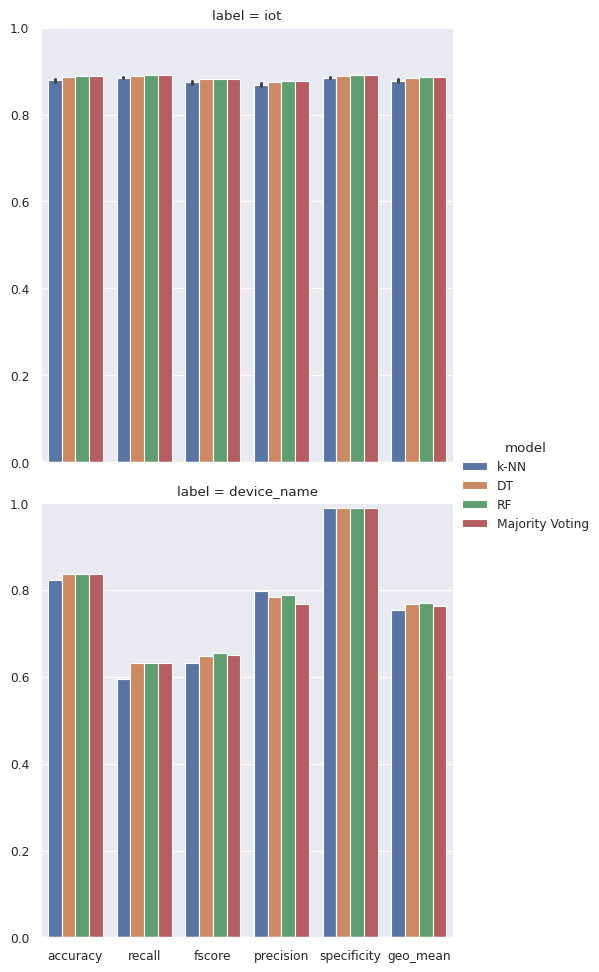

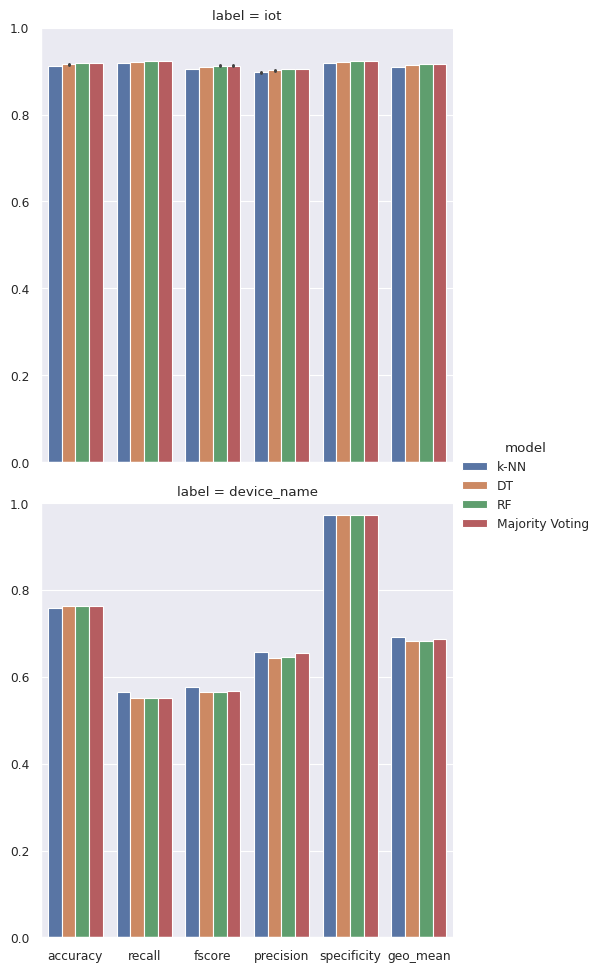

In [51]:
def draw_performance_plot(scores):
    sns.catplot(scores, x="model", y="accuracy", kind="bar")
    plt.ylim(0, 1)

def draw_multiple_perf(scores):
    plot = sns.catplot(scores, hue="model", y="value", x="measurement", row="label", kind="bar")

    plot.set_ylabels(label="")
    plot.set_xlabels(label="")
    plot.set_titles(col_template="Classifier: {col_name}")

    plt.ylim(0, 1)

draw_multiple_perf(all_scores)
draw_multiple_perf(all_scores_no_cam)

### Experiment 2: Padding

In [26]:
def test_padding(trainer: Trainer, padded_features, draw_graph=False):
    X_test = padded_features.iloc[:, 0:3]
    y_test = padded_features[:][trainer.target_label]

    results = trainer.test(X_test, y_test)

    if draw_graph:
        draw_multiple_perf(results)

    return results

device_features_padded = labeled_features_padded.loc[labeled_features['iot'] == True]

device_trainer.trained_models = all_trained_clfs[2]
iot_trainer.trained_models = all_trained_clfs[0]

device_padded_results = test_padding(device_trainer, device_features_padded)
iot_padded_results = test_padding(iot_trainer, labeled_features_padded)

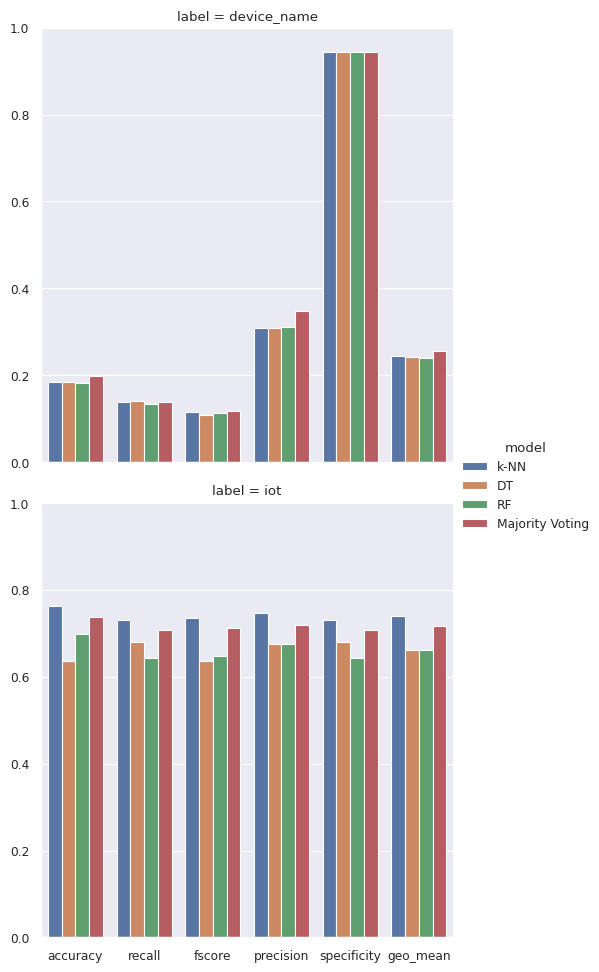

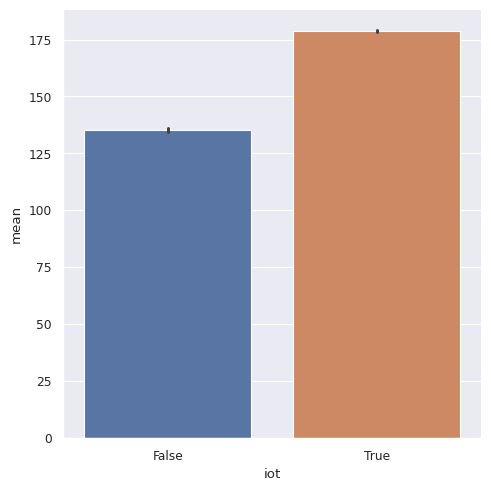

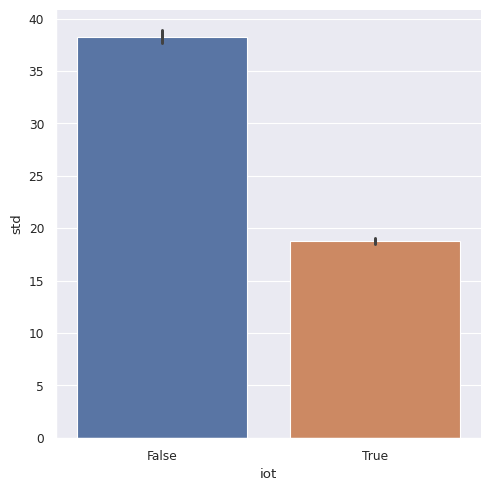

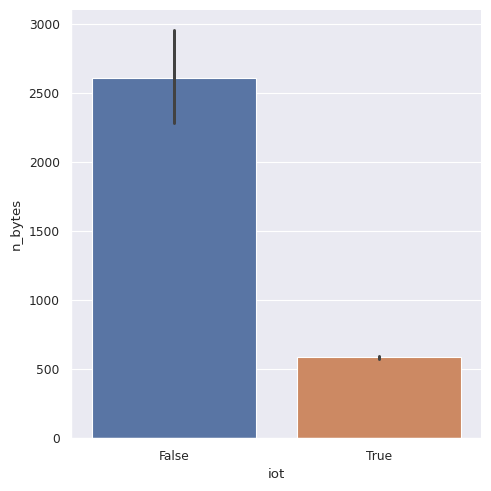

In [27]:
all_padded_results = pd.concat([device_padded_results, iot_padded_results])
draw_multiple_perf(all_padded_results)

sns.catplot(labeled_features_padded, y="mean", x="iot", kind="bar")
sns.catplot(labeled_features_padded, y="std", x="iot", kind="bar")
sns.catplot(labeled_features_padded, y="n_bytes", x="iot", kind="bar")

### Experiment 3: MAC-less 

## Results from the original paper

In [21]:
iot_bin = pd.DataFrame({'Metric': ['precision','precision', 'recall', 'recall', 'fscore', 'fscore', 'specificity', 'specificity', 'geo_mean', 'geo_mean'],
        'Partitioning Method': ['Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological'],
        'k-NN': [97, 95, 97, 95, 97, 95, 85, 95, 90, 95],
        'RF': [97, 96, 96, 96, 96, 96, 97, 96, 96, 96],
        'DT': [97, 96, 97, 96, 97, 96, 87, 96, 92, 96],
        'SVM': [97, 99, 97, 99, 97, 99, 94, 99, 95, 99],
        'Majority Voting': [98, 99, 98, 99, 98, 99, 93, 99, 95, 99]})

iot_device_kf = pd.DataFrame({'Metric': ['precision','precision', 'recall', 'recall', 'fscore', 'fscore', 'specificity', 'specificity', 'geo_mean', 'geo_mean'],
        'Partitioning Method': ['Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological'],
        'k-NN': [94, 92, 94, 92, 94, 92, 99, 99, 97, 95],
        'RF': [96, 94, 96, 94, 96, 94, 99, 99, 98, 96],
        'DT': [96, 94, 96, 94, 96, 94, 99, 99, 97, 96],
        'SVM': [94, 91, 94, 91, 94, 91, 99, 99, 96, 95],
        'Majority Voting': [96, 94, 96, 94, 96, 94, 99, 99, 98, 96]})

        
iot_device_kf_no_cam = pd.DataFrame({'Metric': ['precision','precision', 'recall', 'recall', 'fscore', 'fscore', 'specificity', 'specificity', 'geo_mean', 'geo_mean'],
        'Partitioning Method': ['Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological', 'Random', 'Chronological'],
        'k-NN': [92, 90, 92, 90, 92, 90, 99, 99, 95, 94],
        'RF': [94, 93, 94, 93, 94, 93, 99, 99, 97, 96],
        'DT': [94, 92, 94, 92, 94, 92, 99, 99, 96, 96],
        'SVM': [92, 90, 92, 90, 92, 90, 99, 98, 95, 94],
        'Majority Voting': [94, 93, 94, 93, 94, 93, 99, 99, 97, 96]})

# Drop the 'Random' values as those are not applicable to us

all_ref_results = [iot_bin, iot_device_kf, iot_device_kf_no_cam]
all_ref_results_random = []

for ref_results in all_ref_results:
    res_random = ref_results.loc[ref_results['Partitioning Method'] != 'Random']
    res_random.drop('Partitioning Method', axis=1, inplace=True)
    all_ref_results_random.append(res_random) 

display(all_ref_results_random[0])
display(all_ref_results_random[1])

/tmp/ipykernel_442/1248110846.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_random.drop('Partitioning Method', axis=1, inplace=True)
/tmp/ipykernel_442/1248110846.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_random.drop('Partitioning Method', axis=1, inplace=True)
/tmp/ipykernel_442/1248110846.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_random.drop('Partitioning Method', axis=1, inplace=True)


,Metric,k-NN,RF,DT,SVM,Majority Voting
1,precision,95,96,96,99,99
3,recall,95,96,96,99,99
5,fscore,95,96,96,99,99
7,specificity,95,96,96,99,99
9,geo_mean,95,96,96,99,99


,Metric,k-NN,RF,DT,SVM,Majority Voting
1,precision,92,94,94,91,94
3,recall,92,94,94,91,94
5,fscore,92,94,94,91,94
7,specificity,99,99,99,99,99
9,geo_mean,95,96,96,95,96


In [22]:
def reformat_results(df):
    cols = list(df.columns)
    cols[1] = "metric"
    df.columns = cols
    ref = df.drop('balancing', axis=1)
    return ref.pivot_table(index='metric', columns='model')

display(reproduced.groupby(["model", "metric", "label", "balancing"]).mean())
iot_repr = reproduced.loc[reproduced['label'] == 'iot'].drop('label', )

reformatted = reformat_results(reproduced)
print(reformatted)
print(all_ref_results_random[0])

KeyError: 'metric'